# Federated Averaging Logistic Regression

## Set up Data Federation

In [47]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

def get_iris_dataframe():

    iris = load_iris()
    df1 = pd.DataFrame(iris.data, columns=iris.feature_names)
    target = iris.target_names
    encoder = OneHotEncoder(sparse=False)
    target =encoder.fit_transform(iris.target.reshape(-1, 1))
    df2 =pd.get_dummies(pd.DataFrame(target, columns=iris.target_names))
    dataframe = pd.concat([df1, df2], axis=1)

    return dataframe

def get_test_federation_split(df1):

    train = df1.sample(frac=0.8,random_state=0)
    test = df1.drop(train.index)

    train1 = train.sample(frac=0.5,random_state=0)
    train2 = train.drop(train1.index)

    return train1, train2, test

dataframe = get_iris_dataframe()
train_1, train_2, test = get_test_federation_split(dataframe)
data_federation = [train_1, train_2]

## Run Federated Averaging

In [49]:
from sail_safe_functions_orchestrator.machine_learning.federated_averaging import federated_averaging
from helper_libs.shared.models.LogisticRegression import LogisticRegression


X_col = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Y_col = ['setosa', 'versicolor', 'virginica']
in_layer = len(X_col)
out_layer = len(Y_col)
optimizer = "SGD"
criterion = "MSELoss"
starting_model = LogisticRegression(in_layer, out_layer)
learn_rate = 0.1
epochs=5000
federal_epochs=2

model = federated_averaging(epochs, federal_epochs, data_federation, X_col, Y_col, learn_rate, starting_model, criterion, optimizer)

### Compare Random and Trained Models

/tmp/ipykernel_11102/1403080379.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(column_a, predictions, 'go', label='Predictions', color="red", alpha=0.2)


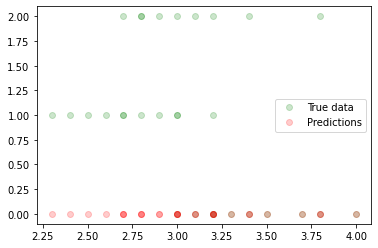

/tmp/ipykernel_11102/1403080379.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(column_a, predictions, 'go', label='Predictions', color="red", alpha=0.2)


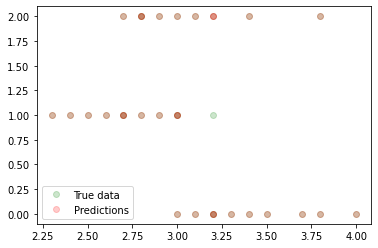

In [59]:
import torch
import matplotlib.pyplot as plt

def print_graph(predicted, x_train, y_train):


    predictions = []
    for prediction in predicted:
            predictions.append(prediction.argmax())

    labels = []
    for y in y_train:
            labels.append(int(y.argmax()))

    column_a = []
    for x in x_train:
        column_a.append(x[1])

    plt.plot(column_a, labels, 'go', label='True data', alpha=0.2)
    plt.plot(column_a, predictions, 'go', label='Predictions', color="red", alpha=0.2)
    plt.legend(loc='best')
    plt.show()

X_test = torch.Tensor(test[X_col].values).float()
Y_test = torch.Tensor(test[Y_col].values).float()

predicted = starting_model(X_test)
print_graph(predicted, X_test, Y_test)

predicted = model(torch.Tensor(test[X_col].values).float())
print_graph(predicted, X_test, Y_test)